# The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

## 1. Load  “bank-full.csv” dataset and create a logistic regression model for predicting target variable (subscribed a term deposit or not). Use appropriate evaluation methods and report the performance of the model using appropriate metrics.

### Preprocessing


In [215]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report,average_precision_score,precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count() or 1) ## added this to fix errors in q5 code

### Loading dataset and preprocessing 


In [149]:
df = pd.read_csv("bank-full.csv", sep=";") # use ";" as delimiter to split the columns properly
print("Shape: ",  df.shape)

Shape:  (45211, 17)


In [150]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [152]:
X = df.drop('y', axis=1) # axis=1 means splits between columns and not rows 
Y = df['y']

# check shapes and peek features and target dataframes
print("Shape of X: ", X.shape)
print(X.head())
print("\nShape of Y: ", Y.shape)
print(Y.head())

Shape of X:  (45211, 16)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome  
0  unknown    5   may       261         1     -1         0  unknown  
1  unknown    5   may       151         1     -1         0  unknown  
2  unknown    5   may        76         1     -1         0  unknown  
3  unknown    5   may        92         1     -1         0  unknown  
4  unknown    5   may       198         1     -1         0  unknown  

Shape of Y:  (45211,)
0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object


### Encode categorical values in X and encode Y 

In [154]:
X_binary_cols = ['default', 'housing', 'loan']
X_cat_cols = [col for col in X.select_dtypes(include=['object']).columns if col not in X_binary_cols]
# print("cat cols: ", X_cat_cols)

# Encoding X columns
le = LabelEncoder()
for col in X_binary_cols:
    X[col] = le.fit_transform(X[col])

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encodedCat = encoder.fit_transform(X[X_cat_cols])

#Concatenate both binary and cat_cols
# 1) One-hot → DataFrame with names and aligned index
encoded_cat_df = pd.DataFrame(
    X_encodedCat,
    columns=encoder.get_feature_names_out(X_cat_cols),
    index=X.index
)

# 2) Base = X minus the original binary + categorical columns
X_base = X.drop(columns=X_binary_cols + X_cat_cols)

# 3) Concatenate: base (numeric etc.) + encoded binary (already 0/1 in X) + one-hot cats
X_encoded = pd.concat([X_base, X[X_binary_cols], encoded_cat_df], axis=1)


print(X_encoded.shape)
print(X_encoded.head())

#encode Y 
Y_encoded = y = pd.Series(le.fit_transform(Y))
print("Y_encoded series")
print(Y_encoded.head())

(45211, 42)
   age  balance  day  duration  campaign  pdays  previous  default  housing  \
0   58     2143    5       261         1     -1         0        0        1   
1   44       29    5       151         1     -1         0        0        1   
2   33        2    5        76         1     -1         0        0        1   
3   47     1506    5        92         1     -1         0        0        1   
4   33        1    5       198         1     -1         0        0        0   

   loan  ...  month_jul  month_jun  month_mar  month_may  month_nov  \
0     0  ...        0.0        0.0        0.0        1.0        0.0   
1     0  ...        0.0        0.0        0.0        1.0        0.0   
2     1  ...        0.0        0.0        0.0        1.0        0.0   
3     0  ...        0.0        0.0        0.0        1.0        0.0   
4     0  ...        0.0        0.0        0.0        1.0        0.0   

   month_oct  month_sep  poutcome_other  poutcome_success  poutcome_unknown  
0       

In [155]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  int64  
 1   balance              45211 non-null  int64  
 2   day                  45211 non-null  int64  
 3   duration             45211 non-null  int64  
 4   campaign             45211 non-null  int64  
 5   pdays                45211 non-null  int64  
 6   previous             45211 non-null  int64  
 7   default              45211 non-null  int32  
 8   housing              45211 non-null  int32  
 9   loan                 45211 non-null  int32  
 10  job_blue-collar      45211 non-null  float64
 11  job_entrepreneur     45211 non-null  float64
 12  job_housemaid        45211 non-null  float64
 13  job_management       45211 non-null  float64
 14  job_retired          45211 non-null  float64
 15  job_self-employed    45211 non-null 

### Data partitioning between training, validation and test. 

In [157]:
# 20% test, 80% train + val
X_trval, X_test, y_trval, y_test = train_test_split(
    X_encoded, Y_encoded, test_size=0.2, random_state=42, stratify=y
)

# 25% of training data for validation while 75% of training data for actual training
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.25, random_state=42, stratify=y_trval
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform training
X_test_scaled = scaler.transform(X_test)        # transform test only


### Training the model and predicting y

In [159]:
# Model (balanced handles class imbalance; increase max_iter for convergence)
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred  = logreg.predict(X_test_scaled) #for: accuracy, precision, recall, F1, confusion matrix, classification report.
y_proba = logreg.predict_proba(X_test_scaled)[:, 1] #for: ROC curve & ROC-AUC (and any custom-threshold analysis).



### Evaluating the model 

Accuracy : 0.8457
Precision: 0.4185
Recall   : 0.8176
F1-score : 0.5536

ROC AUC  : 0.9079
PR  AUC  : 0.5371





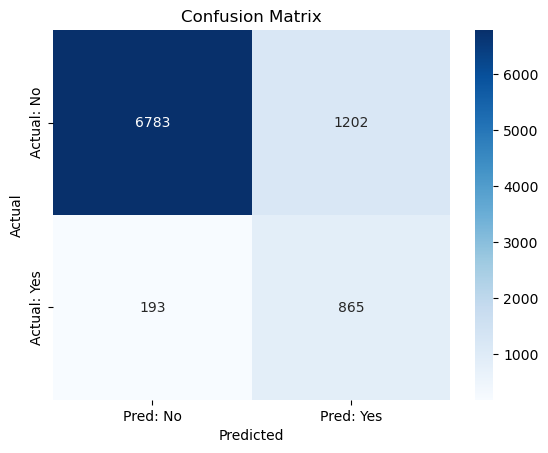

In [161]:

# Choose a decision threshold (default 0.5)
threshold = 0.5 # is a hyperparameter that can be tuned to boost precision and recall 
y_pred = (y_proba >= threshold).astype(int)

# Metrics based on class labels (using y_pred)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
cm   = confusion_matrix(y_test, y_pred)

# Threshold-free metrics based on probabilities (use y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc  = average_precision_score(y_test, y_proba)  # aka AP; PR-AUC

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")
print(f"ROC AUC  : {roc_auc:.4f}")
print(f"PR  AUC  : {pr_auc:.4f}\n\n\n")

# Confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


## Q2.  Have you used any hyperparameter tuning while building the model in Q1? If yes,  then plot  the  performances  that were obtained at different steps of optimisation. Otherwise, create an optimised model and compare performance with Q1.

In [178]:
import itertools

param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [300, 1000],
}

results = []

for solver, class_weight, max_iter in itertools.product(
        param_grid['solver'], param_grid['class_weight'], param_grid['max_iter']):

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver=solver,
                                   class_weight=class_weight,
                                   max_iter=max_iter))
    ])

    # Train ONLY on training data
    pipe.fit(X_train, y_train)

    # Validate ONLY on X_trval, y_trval
    proba_val = pipe.predict_proba(X_trval)[:, 1]
    pr_auc = average_precision_score(y_trval, proba_val)

    results.append({
        'solver': solver,
        'class_weight': class_weight if class_weight is not None else 'None',
        'max_iter': max_iter,
        'val_PR_AUC': pr_auc
    })


# Neat table sorted by PR-AUC (higher is better)
df_results = pd.DataFrame(results).sort_values('val_PR_AUC', ascending=False).reset_index(drop=True)
df_results


,solver,class_weight,max_iter,val_PR_AUC
0,lbfgs,None,300,0.555917
1,lbfgs,None,1000,0.555917
2,liblinear,None,300,0.555908
3,liblinear,None,1000,0.555908
4,lbfgs,balanced,300,0.549203
5,lbfgs,balanced,1000,0.549203
6,liblinear,balanced,300,0.549168
7,liblinear,balanced,1000,0.549168


### Comparing results with different hyperparameters and with q1


In [185]:

# ---- 1. Train baseline model on training data ----
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000
    ))
])
baseline_model.fit(X_train, y_train)

# ---- 2. Get predicted probabilities on validation set ----
val_proba = baseline_model.predict_proba(X_val)[:, 1]

# ---- 3. Sweep thresholds and compute Precision/Recall/F1 ----
thresholds = np.linspace(0.05, 0.95, 19)  # from 0.05 to 0.95 in steps of 0.05
records = []
for t in thresholds:
    y_pred = (val_proba >= t).astype(int)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    f1   = f1_score(y_val, y_pred, zero_division=0)
    records.append({'threshold': t, 'precision': prec, 'recall': rec, 'f1': f1})

# ---- 4. Find best threshold by F1 ----
results = pd.DataFrame(records)
best_row = results.loc[results['f1'].idxmax()]
best_threshold = best_row['threshold']

print("=== Baseline Model: Threshold tuning on Validation Set ===")
print(results.round(4))
print(f"\nBest threshold: {best_threshold:.2f} "
      f"(F1={best_row['f1']:.4f}, "
      f"Precision={best_row['precision']:.4f}, "
      f"Recall={best_row['recall']:.4f})")




=== Baseline Model: Threshold tuning on Validation Set ===
    threshold  precision  recall      f1
0        0.05     0.1388  0.9972  0.2436
1        0.10     0.1683  0.9953  0.2879
2        0.15     0.2036  0.9877  0.3376
3        0.20     0.2405  0.9735  0.3857
4        0.25     0.2764  0.9556  0.4288
5        0.30     0.3078  0.9386  0.4636
6        0.35     0.3377  0.9093  0.4924
7        0.40     0.3649  0.8819  0.5162
8        0.45     0.3903  0.8526  0.5355
9        0.50     0.4153  0.8138  0.5500
10       0.55     0.4387  0.7873  0.5634
11       0.60     0.4707  0.7524  0.5791
12       0.65     0.4915  0.7127  0.5818
13       0.70     0.5147  0.6635  0.5797
14       0.75     0.5462  0.6087  0.5758
15       0.80     0.5816  0.5624  0.5718
16       0.85     0.6038  0.4868  0.5390
17       0.90     0.6379  0.4045  0.4951
18       0.95     0.6644  0.2788  0.3928

Best threshold: 0.65 (F1=0.5818, Precision=0.4915, Recall=0.7127)


### Q3. Create  two  regularized  logistic  regression   models  for  the predicting the target variable using the evaluation setting that you have used Q1 and report the performance.|

## L2 (Ridge) 

=== L2-Regularised Logistic Regression (Ridge) ===
Accuracy : 0.8457
Precision: 0.4185
Recall   : 0.8176
F1-score : 0.5536
ROC AUC  : 0.9079
PR  AUC  : 0.5371

Classification Report:
               precision    recall  f1-score   support

           0     0.9723    0.8495    0.9068      7985
           1     0.4185    0.8176    0.5536      1058

    accuracy                         0.8457      9043
   macro avg     0.6954    0.8335    0.7302      9043
weighted avg     0.9075    0.8457    0.8654      9043



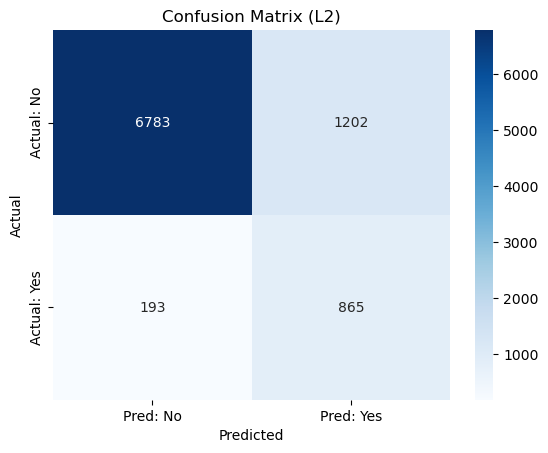

In [189]:
# ---- Train L2-regularised logistic regression (Ridge) ----
l2_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',       # L2 regularisation
        solver='lbfgs',     # supports L2
        class_weight='balanced',  # still account for imbalance
        max_iter=1000,
        C=1.0               # regularisation strength (default = 1.0)
    ))
])

l2_model.fit(X_train, y_train)

# ---- Predict on test set ----
y_proba = l2_model.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)  # default threshold 0.5

# ---- Metrics ----
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)
pr   = average_precision_score(y_test, y_proba)

print("=== L2-Regularised Logistic Regression (Ridge) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")
print(f"PR  AUC  : {pr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (L2)')
plt.show()

## L1 (Lasso)

=== L1-Regularised Logistic Regression (Lasso) ===
Accuracy : 0.8456
Precision: 0.4183
Recall   : 0.8176
F1-score : 0.5534
ROC AUC  : 0.9080
PR  AUC  : 0.5371

Classification Report:
               precision    recall  f1-score   support

           0     0.9723    0.8493    0.9067      7985
           1     0.4183    0.8176    0.5534      1058

    accuracy                         0.8456      9043
   macro avg     0.6953    0.8335    0.7301      9043
weighted avg     0.9075    0.8456    0.8654      9043



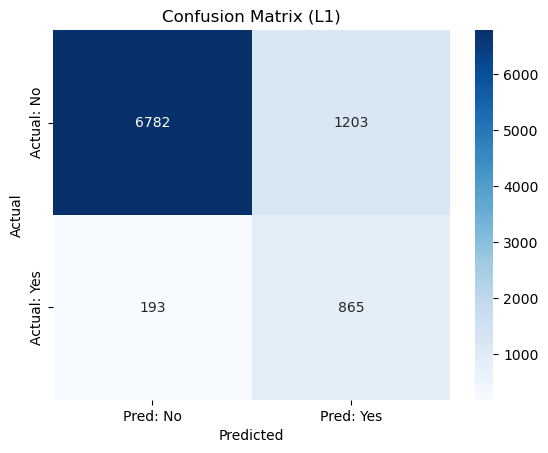

In [192]:
# ---- Train L1-regularised logistic regression (Lasso) ----
l1_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',       # L1 regularisation
        solver='liblinear', # required for L1
        class_weight='balanced',  # handle imbalance
        max_iter=1000,
        C=1.0               # regularisation strength (default = 1.0)
    ))
])

l1_model.fit(X_train, y_train)

# ---- Predict on test set ----
y_proba = l1_model.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)  # default threshold 0.5

# ---- Metrics ----
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)
pr   = average_precision_score(y_test, y_proba)

print("=== L1-Regularised Logistic Regression (Lasso) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")
print(f"PR  AUC  : {pr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (L1)')
plt.show()

### Comparing L1, L2 and Baseline models 


### Report of the performance 

## Q4. Compare the performance of the three models (Q1 and Q3), explain which model is good and why.

## Q5. Continue from question 4, with the same evaluation setting, use KNN and tune K on the training set, report the performance on the test set and the optimal K. Compare KNN with all the above logistic  regression  models,  consider  the  following  aspects: number  of  trainable  parameters,  training  time  and  model performance.  Explain  why  KNN  is  worse/better  than  logistic regression. 

### Buiding a KNN model with different k values and validating using validation dataset to find the optimal k

In [219]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Candidate K values
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31, 41, 51, 61, 81, 101, 131, 161]

knn_results = []

for k in k_values:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=k, weights='uniform',
                                     metric='minkowski', p=2))
    ])
    # Fit on training only
    knn_pipe.fit(X_train, y_train)

    # Validate on X_val to pick best K
    val_proba = knn_pipe.predict_proba(X_val)[:, 1]
    pr_auc   = average_precision_score(y_val, val_proba)
    roc_auc  = roc_auc_score(y_val, val_proba)

    knn_results.append({
        'K': k,
        'val_PR_AUC': pr_auc,
        'val_ROC_AUC': roc_auc
    })

# sorted results for K
knn_df = pd.DataFrame(knn_results).sort_values('val_PR_AUC', ascending=False).reset_index(drop=True)
print("\n=== KNN validation results (sorted by PR-AUC) ===")
print(knn_df.round(4))

# Select best K by PR-AUC 
best_k = int(knn_df.loc[0, 'K'])
print(f"\nBest K (by PR-AUC on validation): {best_k}")


=== KNN validation results (sorted by PR-AUC) ===
      K  val_PR_AUC  val_ROC_AUC
0    31      0.5064       0.8796
1    61      0.5038       0.8836
2    51      0.5026       0.8816
3    41      0.5026       0.8814
4    21      0.4998       0.8733
5    81      0.4973       0.8832
6   101      0.4920       0.8816
7   131      0.4903       0.8823
8   161      0.4894       0.8815
9    15      0.4871       0.8641
10   11      0.4701       0.8547
11    9      0.4594       0.8481
12    7      0.4392       0.8353
13    5      0.4093       0.8136
14    3      0.3528       0.7644
15    1      0.2541       0.6720

Best K (by PR-AUC on validation): 31


### Final evaluation using best k-value KNN on test data


=== Final KNN Evaluation (K=31) ===
Accuracy : 0.8961
Precision: 0.6528
Recall   : 0.2382
F1-score : 0.3490
ROC AUC  : 0.8701
PR  AUC  : 0.4909

Classification Report:
               precision    recall  f1-score   support

           0     0.9069    0.9832    0.9435      7985
           1     0.6528    0.2382    0.3490      1058

    accuracy                         0.8961      9043
   macro avg     0.7799    0.6107    0.6463      9043
weighted avg     0.8772    0.8961    0.8740      9043



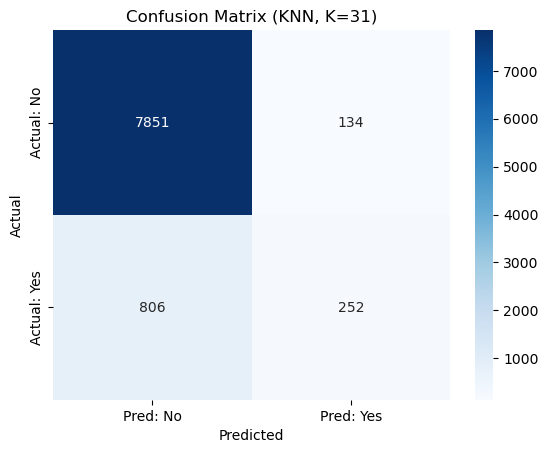

In [228]:
# --- Final KNN with K=31 ---
knn_final = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(
        n_neighbors=31,      # best K from validation
        weights='uniform',   # you could also try 'distance'
        metric='minkowski',  # Euclidean distance
        p=2
    ))
])

# Fit on train+val (X_trval)
knn_final.fit(X_trval, y_trval)

# Evaluate on Test set 
y_proba = knn_final.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)  # default threshold 0.5

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)
pr   = average_precision_score(y_test, y_proba)

print("\n=== Final KNN Evaluation (K=31) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc:.4f}")
print(f"PR  AUC  : {pr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (KNN, K=31)')
plt.show()

### Comparing KNN results with baseline logistic regression and regularized logistic regression models 